In [45]:
!pip install torchinfo # do funkcji summary


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [46]:
import numpy as np
import torch
from scipy.signal import convolve2d
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

### Jak zrobić zadanie

Notebook składa się z 4 zadań, jednak **najważniejsze są zadania 3 i 4**, bo dotyczą stricte własnej implementacji sieci konwolucyjnej. W poszczególnych sekcjach znajdują się opisy które powinny wystarczyć do zrozumienia i implementacji, ale poniżej zamieszczone są źródła do dalszej nauki.

Zbiorem danych będzie *FashionMNIST* lub *CIFAR10* (w zależności od waszej preferencji).

Źródła
- https://visionbook.mit.edu/convolutional_neural_nets.html -> na pograniczu CV i CNN
- https://engineering.purdue.edu/DeepLearn/pdf-kak/DemystifyConvo.pdf -> przydatne do zadania z konwolucją
- https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks#layer -> wizualizacje
- https://guandi1995.github.io/Padding/ -> objaśnienie paddingu
- https://cs231n.github.io/convolutional-networks/ -> kurs od stanford
- warstwy w PyTorch: [Conv2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [MaxPool2d
](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d), [BatchNorm2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d), [Dropout2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html#torch.nn.Dropout2d)


### 0. Po co nam coś więcej niż MLP?

Na poprzedniej liście spłaszczaliśmy obrazki, aby móc je przepuścić przez sieć FNN, jednak taki preprocessing do formy tabelarycznej gubi istotne informacje. Po pierwsze, piksele blisko siebie w oryginalnym obrazie mogą znaleźć się daleko od siebie, dodatkowo wszystkie piksele będą "wymieniać" się sygnałami z wszystkimi innymi pikselami. Jest to mechanizm dosyć nieefektywny (w szarym obrazku o rozmiarze 128x128 mamy na wejściu już 16 384 cech!) i tu na pomoc przychodzą konwolucje.

### 1. Konwolucja

Podstawową operację konwolucji jest lepiej sobie zobrazować (pun intended) na podstawie jednego, oczywistego przykładu. Załóżmy, że mamy obraz binarny (czyli składający się z 0 i 1). Jest to typowa reprezentacja maski w zadaniu segmentacji - 1 oznacza, że na danym pikselu jest interesujący nas obiekt, a 0 to tło.

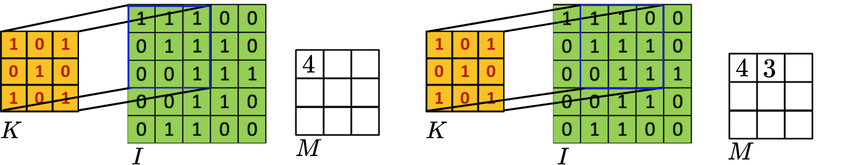

Wyjaśnienie symboli na obrazku
- $I$ - obrazek wejściowy
- $K$ - filtr (kernel) o wymiarze 3x3
- $M$ - wyjściowa mapa cech

Wynik przesuwania się filtra po wejściowej mapie można opisać wzorem

$$(K ⋆ I)(i, j) = \sum_{a=0}^{H_k-1}\sum_{b=0}^{W_k-1} K(a, b)I(i + a, j + b)$$

opisuje to jaki będzie wynik w pikselu o współrzędnych (i, j) w wynikowej mapie $M$. $H_k$ i $W_k$ oznaczają odpowiednio wysokość i szerokość filtra - często rozważamy kwadratowe rozmiary, $H_k$ = $W_k$.


(Tak naprawdę wzór wyżej opisuje korelację wzajemną - *cross-correlation*, ponieważ matematyczna operacja konwolucji dałaby wynik obrócony o 180 stopni)

Taka prosta formulacja nie uwzględnia faktu, że obrazki (zwykle) zawierają kanał koloru RGB. W takim razie filtr $K$ ma teraz możliwe współrzędne $K_{a,b,d}$. Wiemy już z poprzednich list, że budująć sieć neuronową chcemy zwiększyć liczbę ukrytych wymiarów. Dlatego też, aby zwiększyć liczbę kanałów z 3 (rgb) na $Q_k$, nasz filtr musi mieć 4 wymiary, więc indeksować się jako $K_{a,b,d,q}$. To oznacza, że mamy $Q_k$ pojedynczych filtrów, które będą przesuwać się po wejściowym obrazku. Ostatecznie konwolucja będzie mieć postać

$$M_{i,j,q} = \sum_{a=0}^{H_k-1}\sum_{b=0}^{W_k-1}\sum_{d=0}^{D_I-1}K(a, b, d, q)I(i + a, j + b, d)$$

Wynikowy rozmiar takiej mapy nie jest domyślnie równy wejściowemu obrazkowi (lub mapie). Wynika to z tego, że musimy wybrać tylko te "kawałki" obrazka, które w pełni mieszczą się w filtrze (później powiemy o paddingu). Zakładając, że obrazki są mają wymiar $H_I \times W_I \times D_I$, kernel $H_k \times W_k \times D_I \times Q_k$ to wynikowy rozmiar ma postać $$(H_I - H_k + 1) \times (W_I - W_k + 1) \times Q_k$$

Przesuwając kolejno filtr o jedną pozycję (jak dalej się dowiemy, krok jaki wykonuje filtr odnosi się do parametru *stride*) obliczamy wynikową mapę. Wartości w mapie $W$ nie są zwykle z góry znane (tym bardziej nie są binarne jak w prostym przykładzie wyżej), ale wyuczane w procesie trenowania sieci.


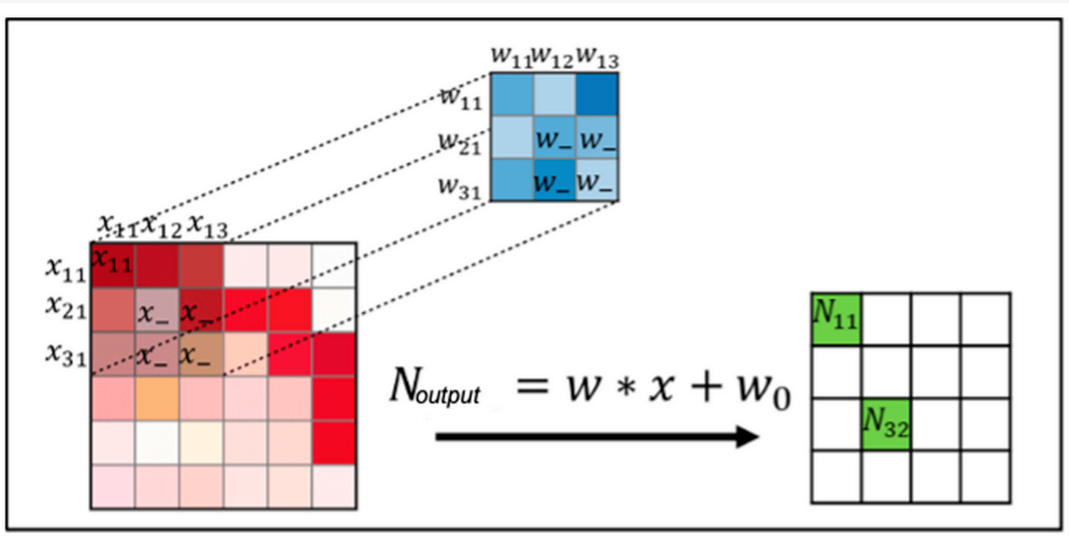

Polecam zajrzeć tutaj po interaktywną wizualizację https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks

### Zadanie 1
Bazując na opisie wyżej i wiarygodnych źródłach, napisz własną implementację operacji konwolucji. Może ona opierać się na macierzach NumPy lub PyTorch. Wykorzystaj poniższą linijkę z testami, aby sprawdzić swoje rozwiązanie.

Ekstra: pomyśl, czy dałoby się zapisać taką operację czysto w sposób macierzowy, pozbywając się pętli (lub chociaż ograniczając ich liczbę).

*Ekstra: pomyśl o dodaniu paddingu (może być to wartość 0), aby mapa wyjściowa była równa rozmiarowo wejściu (wtedy też musisz zmienić padding w testach).

In [47]:
def convolution(X, K, q: int):
  '''
  Wykonuje operację konwolucji na wejściowym obrazie *X* oraz filtrze *K*. Zwraca wynikową mapę.
  Args:
    X: numpy / torch tensor o wymiarach (h, w, d)
    K: numpy / torch tensor o wymiarach (k, k, d, q)
    q: liczba filtrów
  '''

  # TO JEST FEJKOWA IMPLEMENTACJA - USUŃ TO I PISZ KOD TUTAJ
  h, w, d = X.shape
  k, _, _, _ = K.shape
    
  out_h = h - k + 1
  out_w = w - k + 1
    
  S = np.zeros((out_h, out_w, q))
    
  for a in range(out_h):
      for b in range(out_w):
          window = X[a:a+k,b:b+k,:]
          for d in range(q):
            S[a, b, d] = np.sum(window * K[:,:,:,d])
    
  return S

#### Przypadki testowe
Nie musisz nic tutaj modyfikować z wyjątkiem gdy używasz NumPy (w kodzie są zaznaczone linijki, które trzeba odkomentować)

In [48]:
def generate_deterministic_tensor(shape, mod_val=5, offset=0):
    count = 1
    for s in shape:
        count *= s
    # Tworzymy sekwencję 0, 1, 2... i bierzemy modulo
    data = torch.arange(count).float() % mod_val + offset
    return data.reshape(shape)

def torch_2_numpy(pt):
  return pt.detach().numpy()

def run_pytorch_test(case_name, img_hwc, kernel_hwcn):
    image_hwc = generate_deterministic_tensor(img_hwc, mod_val=5)
    kernel_hwcn = generate_deterministic_tensor(kernel_hwcn, mod_val=3, offset=-1)

    print(f"Input shape (H,W,C): {tuple(image_hwc.shape)}")
    print(f"Kernel shape (H,W,Cin,Cout): {tuple(kernel_hwcn.shape)}")

    # Dodanie wymiaru batcha
    input_tensor = image_hwc.permute(2, 0, 1).unsqueeze(0)
    weights = kernel_hwcn.permute(3, 2, 0, 1)
    output_tensor = F.conv2d(input_tensor, weights, stride=1, padding=0)
    output_hwc = output_tensor.squeeze(0).permute(1, 2, 0)

    # ODKOMENTUJ JEŚLI twoim inputem jest wielowymiarowa macierz NumPy
    image_hwc = torch_2_numpy(image_hwc)
    kernel_hwcn = torch_2_numpy(kernel_hwcn)

    my_output = convolution(image_hwc, kernel_hwcn, kernel_hwcn.shape[-1])
    if isinstance(my_output, np.ndarray):
        my_output = torch.from_numpy(my_output)

    my_output = my_output.to(torch.float64)
    output_hwc = output_hwc.to(torch.float64) # do samego typu żeby nie było błędu

    try:
      torch.testing.assert_close(my_output, output_hwc, rtol=1e-05, atol=1e-08)
      print(f"Test zaliczony")
    except AssertionError as e:
      print(f"Test niezaliczony: {e}")
    print(f"Output shape (H,W,C): {tuple(output_hwc.shape)}")

# --- URUCHOMIENIE PRZYPADKÓW ---

# Przypadek 1: Mały
run_pytorch_test("PRZYPADEK 1", (6, 6, 3), (3, 3, 3, 5))

# Przypadek 2: Średni
run_pytorch_test("PRZYPADEK 2", (12, 12, 3), (3, 3, 3, 5))

# Przypadek 3: Projekcja 1x1
run_pytorch_test("PRZYPADEK 3", (24, 24, 3), (1, 1, 3, 10))

Input shape (H,W,C): (6, 6, 3)
Kernel shape (H,W,Cin,Cout): (3, 3, 3, 5)
Test zaliczony
Output shape (H,W,C): (4, 4, 5)
Input shape (H,W,C): (12, 12, 3)
Kernel shape (H,W,Cin,Cout): (3, 3, 3, 5)
Test zaliczony
Output shape (H,W,C): (10, 10, 5)
Input shape (H,W,C): (24, 24, 3)
Kernel shape (H,W,Cin,Cout): (1, 1, 3, 10)
Test zaliczony
Output shape (H,W,C): (24, 24, 10)


### 2. Porównanie konwolucji i sieci w pełni połączonej

| Cecha | Konwolucja (CNN) | Sieć w pełni połączona (FNN / Dense) |
| :--- | :--- | :--- |
| **1. Wagi/Parametry** | **Współdzielone (Parameter Sharing)**<br>Ten sam zestaw wag (filtr) jest używany do skanowania całego obrazu | **Indywidualne**<br>Każde połączenie ma własną wagę przypisaną do konkretnego piksela/pozycji na wejściu |
| **2. Zasięg działania** | **Lokalny**<br>Operacja dotyczy tylko małego wycinka (okna) wokół aktualnie przetwarzanego punktu | **Globalny**<br>Każdy neuron w warstwie ukrytej "widzi" i jest połączony ze wszystkimi pikselami obrazu wejściowego |
| **3. Przesunięcie obiektu** | **Ekwiwariancja na translację**<br>Jeśli obiekt (np. kot) przesunie się na obrazie, sieć nadal go wykryje (tylko w innym miejscu mapy cech) | **Wrażliwość na pozycję**<br>Sieć musi "nauczyć się" wyglądu kota w każdym możliwym położeniu osobno, traktując je jako zupełnie nowe wzorce |
| **Efektywność** | Mniejsza liczba parametrów (dzięki współdzieleniu wag), szybsze uczenie obrazów | Ogromna liczba parametrów przy dużych obrazach, wysokie ryzyko przeuczenia |

### 3. Pole recepcyjne

Po angielsku *receptive field* odnosi się do wszystkich możliwych miejsc na obrazku, jak i na poprzednich mapach, które mogą wpływać na wynik w aktualnie rozważanym elemencie. Lepiej to obrazuje załączony schemat, gdzie widzimy jak element po środku tak naprawdę posiada informacje z poprzednich warstw. Jest to główna koncepcja w kontekście projektowania architektur konwolucyjnych sieci neuronowych, gdzie głębsze warstwy uczą się bardziej skomplikowanych struktur bazując na prymitywnych kształtach zidentyfikowanych na niższych warstwach.

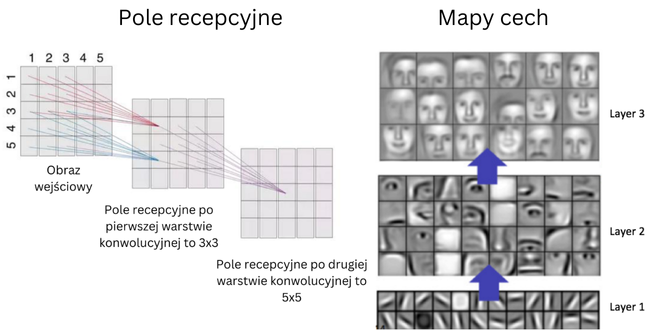

### 4. Operacja Poolingu

Aby jeszcze bardziej zmniejszyć rozmiar wynikowej mapy (tj. jej szerokość i wysokość) stosuje się operacje *max* lub *avg* pooling. Działają one w ten sposób, że na każdym rozłącznym kawałku wejściowego obrazka/mapy wykonujemy pewną redukcję do jednej wartości wyjściowej. Przypomina to operację konwolucji, natomiast nie mamy tutaj żadnych wag kernela, tylko z góry deterministyczną operację. Zastosowanie poolingu na kawałkach $2 \times 2$ zmniejsza wejściowy tensor dwukrotnie (dla $3 \times 3 $ zmniejszy trzykrotnie, i tak dalej). Zdecydowanie bardziej popularny jest **max pooling**, ponieważ przypomina wyciąganie tej najbardziej istotnej informacji z obrazka.

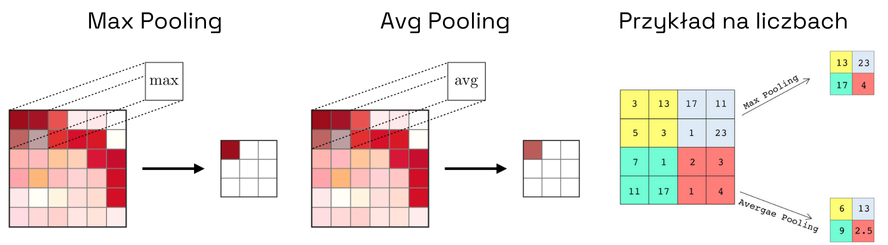

$$M(i, j) = \max_{(a, b) \in 𝒩} I(a, b) ← \text{max pooling} $$  
$$M(i, j) = \frac{1}{|𝒩|} \sum_{(a, b) \in 𝒩} I(a, b)  ← \text{avg pooling}$$

gdzie
- $I$ - wejściowy obrazek lub mapa
- $M$ - wyjściowa mapa
- $𝒩$ - fancy matematyczny znaczek na określenie sąsiedztwa, a w praktyce to zbiór wszystkich pozycji na wejściu $(a, b)$ które są aktualnie w rozważanym obszarze $n \times n$

#### Global Average Pooling

Ważną operacją bezpośrednio przydatną gdy będziemy implementować sieć CNN jest ekstremalna wersja poolingu, która przyjmuje mapę o wymiarze $H \times W \times C$ i zwraca wektor o długości $C$ (Tj. dla każdego kanału $c$ oblicza średnią po $H$ i $W$). Zwykle ta warstwa stanowi pomost między częścią konwolucyjną sieci a częścią w pełni połączoną (FFN).

### 5. Warstwa konwolucji w PyTorch
Zanim zaczniemy budować sieć składającą się z wielu warstw konwolucji, to warto zrozumieć jakie przyjmuje ona (najistotniejsze) parametry

```
class torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
```

- in_channels - liczba filtrów w wejściowej mapie/obrazku. Będzie to 3 dla obrazu RGB, a dla pośrednich map to będzie zależeć od liczby *out_channels* poprzedniej warstwy
- out_channels - liczba filtrów wyjściowych mapy (a jednocześnie liczba filtrów wejściowych do kolejnej warstwy konwolucyjnej)
- kernel_size - tuple (wysokość, szerokość) lub skalar dla kwadratowego filtra, od tej wielkości zależy też wysokość i szerokość wynikowej mapy
- stride - domyślnie 1, określa o ile pikseli przesuwamy się filtrem w każdym kolejnym kroku. Wybranie wartości > 1 ma podobny wpływ jak zastosowanie poolingu
- padding - domyślnie brak, określa jaka jest szerokość ramki, która jest dodawana do wejściowej mapy. Jest to przydatne kiedy chcemy, żeby wielkość wynikowej mapy była równa mapie wejściowej - wtedy podajemy jako wartość 'same' (tylko dla $stride = 1$)
- dilation - domyślnie 1, określa w obrębie samego filtra jaki jest odstęp między pikselami mapy wejściowej
- bias - oznacza to samo co dla warstwy liniowej, może być konieczne ustawienie na *False*

`kernel_size`, `stride`, `padding` i `dilation` mogą być typu `int` dla kwadratowych obszarów, lub `tuple` do określenia oddzielnie wysokości i szerokości

Wzór na wysokość ($H$) i szerokość ($W$) wyjściową ma postać
$$H_{out} = ⌊ \frac{H_{in} + 2 \times padding[0] - dilation[0] \times (kernel\_size[0] - 1) - 1}{stride[0]} + 1⌋$$

$$W_{out} = ⌊ \frac{W_{in} + 2 \times padding[1] - dilation[1] \times (kernel\_size[1] - 1) - 1}{stride[1]} + 1⌋$$

(symbol "podłogi" $⌊$, $⌋$ oznacza zaokrąglenie w dół do liczby całkowitej)

dla kwadratowego wejścia i filtrów upraszcza się to do $H_{out} = W_{out}$



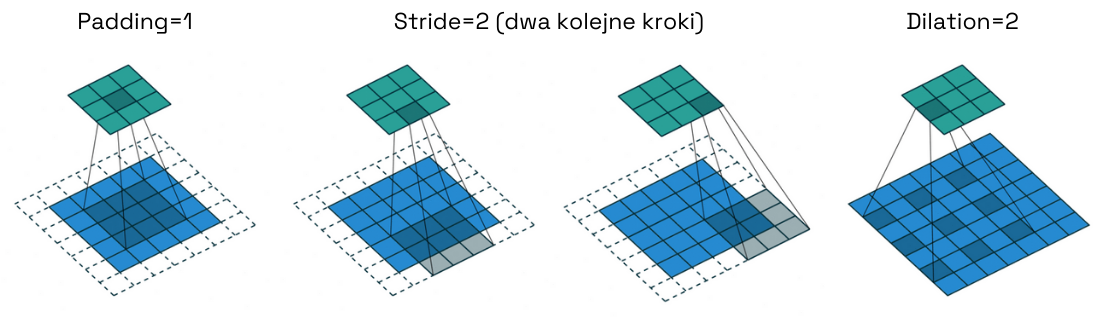

### Zadanie 2
Na podstawie wyżej wyjaśnionych argumentów i wzorów uzupełnij poniżej brakujące wartości. Nie musisz nad tym spędziać nie wiadomo ile czasu, ale warto nabrać intuicji które parametry musisz zmienić i jakie powinny być wartości by uzyskać zamierzoną wyjściową wielkość.

**Uwaga** zgodnie z konwencją Pytorcha, kolejność wymiarów po kolei to ($B$, $D$, $H$, $W$), tak więc wymiar kanału znajduje się nie na końcu, lecz na początku każdego obrazka/mapy. $B$ to batch size równy 1 tutaj.

In [49]:
def validate_layer(case_name, layer, input_shape, expected_shape):
    print(f"--- {case_name} ---")
    print(f"Input: {input_shape}")

    # Tworzymy losowy tensor z batch=1
    x = torch.randn(1, *input_shape)

    try:
        y = layer(x)
        out_shape = tuple(y.shape)[1:] # bez batch

        print(f"Oczekiwany kształt: {expected_shape}")
        print(f"Twój kształt:       {out_shape}")

        if out_shape == expected_shape:
            print("OK. \n")
        else:
            print("Błąd: Kształty się nie zgadzają.\n")

    except Exception as e:
        print(f"Jakiś błąd: {e}\n")

# -------- TEST CASES ---------------

# PRZYPADEK 1: Agresywna redukcja (styl pierwszej warstwy AlexNet)
# Wejście: 224x224 (obraz)
# Wyjście: 55x55
# Wymagane: Użyj Padding=2. Resztę dobierz.
# Wskazówka: Kernel jest duży (>7), a krok (stride) też jest spory (>2).
case_1 = nn.Conv2d(
    in_channels=3,
    out_channels=64,
    padding=2,
    dilation=1,
    # --- DO UZUPEŁNIENIA ---
    kernel_size=9,  # <-- zmień to
    stride=4        # <-- zmień to
)


# Test 1
validate_layer("PRZYPADEK 1: Redukcja 224 -> 55", case_1,
                input_shape=(3, 224, 224),
                expected_shape=(64, 55, 55))

# PRZYPADEK 2: Asymetryczna konwolucja
# Wejście: 32x32
# Wyjście: 30x16
# Wymagane: Padding=0.
# Wskazówka: Wysokość (32->30) maleje wolno, Szerokość (32->16) maleje szybko.
# Użyj krotki (tuple) dla kernel_size i stride, np. (h, w).
case_2 = nn.Conv2d(
    in_channels=1,
    out_channels=1,
    padding=0,
    dilation=1,
    # --- DO UZUPEŁNIENIA ---
    kernel_size=(3, 2), # <-- zmień to
    stride=(1, 2)       # <-- zmień to
)

# Test 2
validate_layer("PRZYPADEK 2: Prostokątne okna 32 -> 30x16", case_2,
                input_shape=(1, 32, 32),
                expected_shape=(1, 30, 16))


# PRZYPADEK 3: "Dziurawy" Kernel (Dilated Convolution)
# Wejście: 50x50
# Wyjście: 46x46
# Wymagane: Stride=1, Padding=0. Kernel ma rozmiar 3x3.
# Zastanów się jak to możliwe, że kernel (3, 3) zmniejsza wielkość aż o 4 piksele?
case_3 = nn.Conv2d(
    in_channels=16,
    out_channels=16,
    stride=1,
    padding=0,
    kernel_size=3,
    # --- DO UZUPEŁNIENIA ---
    dilation=2  # <-- zmień to
)


# Test 3
validate_layer("PRZYPADEK 3: Dylatacja 50 -> 46", case_3,
                input_shape=(16, 50, 50),
                expected_shape=(16, 46, 46))

--- PRZYPADEK 1: Redukcja 224 -> 55 ---
Input: (3, 224, 224)
Oczekiwany kształt: (64, 55, 55)
Twój kształt:       (64, 55, 55)
OK. 

--- PRZYPADEK 2: Prostokątne okna 32 -> 30x16 ---
Input: (1, 32, 32)
Oczekiwany kształt: (1, 30, 16)
Twój kształt:       (1, 30, 16)
OK. 

--- PRZYPADEK 3: Dylatacja 50 -> 46 ---
Input: (16, 50, 50)
Oczekiwany kształt: (16, 46, 46)
Twój kształt:       (16, 46, 46)
OK. 



### 6. Architektura sieci konwolucyjnej

Głębokie sieci konwolucyjne składają się z warstw konwolucyjnych przeplatanych funkcjami aktywacji (zwykle ReLU), operacjami Poolingu, oraz odpowiednikami w 2D Batch Normalization i Dropout (niekoniecznie w tej kolejności). Wraz z kolejnymi warstwami powinna rosnąć liczba filtrów (np. 16 -> 32 -> 64 -> 128 itp.) i zmniejszać się wielkość każdej wynikowej mapy (filtry mają zwykle rozmiar 3x3).

Po serii takich warstw musimy znowu wrócić do w pełni połączonych warstw, z tego powodu stosujemy Global Average Pooling. Typowo taka architektura posłuży do zadania klasyfikacji.  



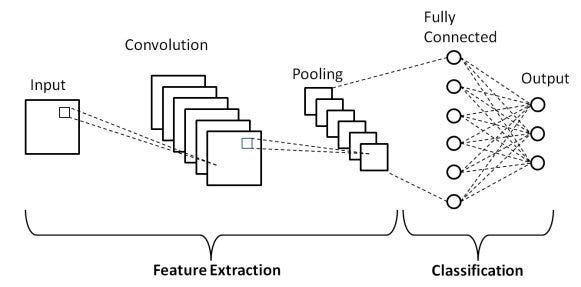

### Zadanie 3

**Zaimplementuj** i **wytrenuj** sieć konwolucyjną do zadania klasyfikacji dla zbioru FashionMNIST lub CIFAR10 (dowolność wyboru) która będzie zawierała następujące elementy
- co najmniej 2 bloki składające się z warstw konwolucyjnych i funkcji aktywacji
- sieci w pełni połączonej (minimalna głębokość to 1) służącej jako klasyfikator (powinno to być łatwe po poprzedniej liście)
- na tym etapie użyj [Flatten](https://docs.pytorch.org/docs/stable/generated/torch.nn.modules.flatten.Flatten.html) do spłaszczenia wymiarów $(B, C, H, W) → (B, C * H * W)$ dla wejścia do warswty liniowej

posłuży ona jako baseline do dalszych eksperymentów. Jeśli dysponujesz siecią FNN z poprzedniej listy, to możesz też odnieść się do jej wyników (nie musisz jej tutaj kopiować i na nowo trenować).

Przebieg trenowania dla sieci konwolucyjnej jest praktycznie taki sam jak do sieci z poprzedniego zadania, tylko że nie spłaszczamy obrazków na wejściu (m. in).

Przykładowy kod do pobrania danych (można go modyfikować):

```python
from torchvision import datasets

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # lub użyjcie innej normalizacji jeśli uznacie za prawidłowe
  ])

trainset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

testset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)
```
**Zwizualizuj** krzywe uczenia tak jak na poprzednich listach i odpowiednie metryki (np. *f1-score* lub *accuracy*)

/var/folders/tm/r7hb9yn13mq_kvy1n4_jlx600000gn/T/ipykernel_61676/1780420991.py:108: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/tm/r7hb9yn13mq_kvy1n4_jlx600000gn/T/ipykernel_61676/1780420991.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


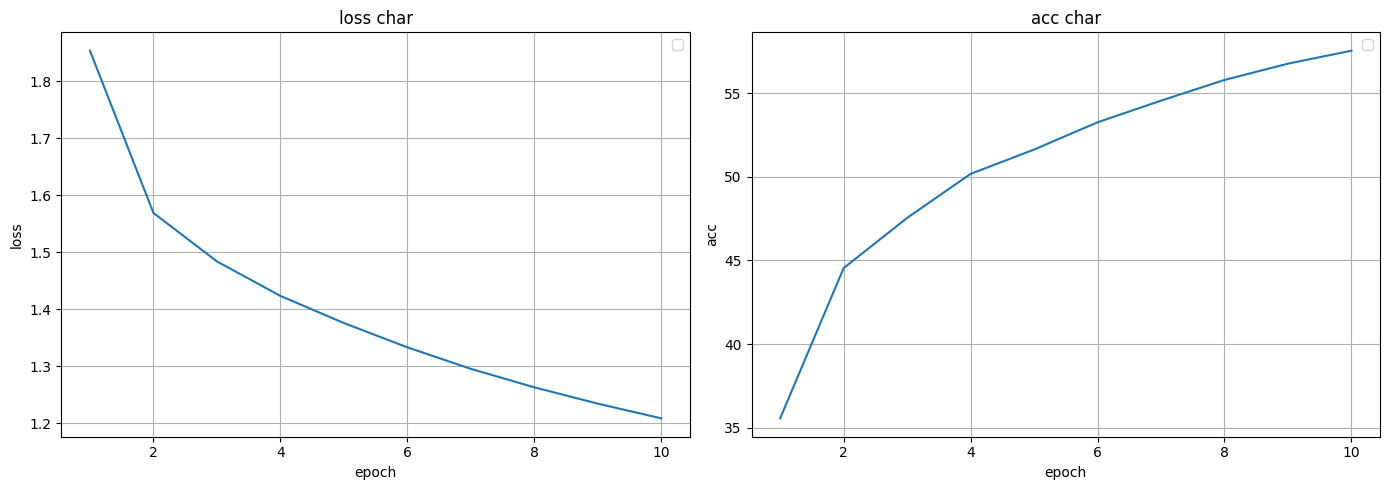

              precision    recall  f1-score   support

    airplane       0.60      0.64      0.62      1000
  automobile       0.72      0.68      0.70      1000
        bird       0.40      0.51      0.45      1000
         cat       0.47      0.29      0.36      1000
        deer       0.53      0.41      0.46      1000
         dog       0.54      0.46      0.49      1000
        frog       0.55      0.75      0.64      1000
       horse       0.63      0.60      0.62      1000
        ship       0.67      0.73      0.70      1000
       truck       0.59      0.63      0.61      1000

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.56     10000
weighted avg       0.57      0.57      0.56     10000



In [50]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # lub użyjcie innej normalizacji jeśli uznacie za prawidłowe
  ])

trainset = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.flatten = nn.Flatten()
        
        self.classifier = nn.Linear(32 * 8 * 8, 10)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x
    
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_tab = []
acc_tab = []
test_acc = []
epochs = 10

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    model.train()
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100 * correct / total
    
    model.eval()
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
    
    epoch_test_acc = 100 * test_correct / test_total
    
    loss_tab.append(epoch_loss)
    acc_tab.append(epoch_acc)
    test_acc.append(epoch_test_acc)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), loss_tab)
plt.title('loss char')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), acc_tab)
plt.title('acc char')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = outputs.max(1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())

class_names = trainset.classes

print(classification_report(y_true, y_pred, target_names=class_names))    

### Zadanie 4

Przeprowadź następujące eksperymenty:

- Eksperyment 1: Dodaj *Max Pooling* w odpowiednim miejscu po warstwach konwolucyjnych. Porównaj z działaniem *Average Pooling*.

- Eksperyment 2: Dodaj warstwę *Global Average Pooling* zamiast spłaszczania tensora przy pomocy Flatten. (Bazuj na sieci z eksperymentu 1)

- Eksperyment 3: Dodaj *Batch Normalization* i/lub *Dropout* w wersji dla 2D. (Bazuj na sieci z eksperymentu 2 z Max Poolingiem)

- Eksperyment 4: Zwiększ liczbę warstw konwolucyjnych i odpowiednio dobierz liczbę filtrów. (Bazuj na sieci z eksperymentu 3)

- Eksperyment 5: Zmień co najmniej 2 wartości domyślne parametrów z listy: `stride`, `dilation`, `padding`. Dlaczego wybrałeś/aś takie parametry i jak poskutkowało ich dodanie? (np. sieć jest mniejsza; wynikowa mapa przed global avg pooling jest mniejsza;)

Po każdej nowej wersji modelu zbadaj jego wielkość

```
summary(model, input_size=(1, 3, 32, 32)) # model to instancja sieci, a obrazki są np. 1x28x28 (MNIST) lub 3x32x32 (CIFAR)
```

Pamiętaj, żeby nie pisać na nowo (bądź kopiować) pętli do trenowania - zwiększy to czytelność notebooka. Również może być pomocna parametryzacja modelu zamiast tworzenie nowej klasy dla każdego eksperymentu z osobna ([ModuleList](https://docs.pytorch.org/docs/stable/generated/torch.nn.ModuleList.html) łączy warstwy w liście wejściowej). **Udokumentuj przebieg eksperymentów** w postaci porównania wybranych metryk i/lub krzywych uczenia.


nie chce mi sie przerabiac tego na gorze i czekac, a z iloscia epok to odlecialem 

In [51]:
def train_model(model,optimizer, epochs=10):
    history = {'tr_loss': [], 'tr_acc': [], 'test_acc': []}
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        model.eval()
        test_correct, test_total = 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        test_acc = 100. * test_correct / test_total
        
        history['tr_loss'].append(epoch_loss)
        history['tr_acc'].append(epoch_acc)
        history['test_acc'].append(test_acc)
    
    return history

## 1. ekspermyent 
maxpool to byl juz w sumie wyzej 


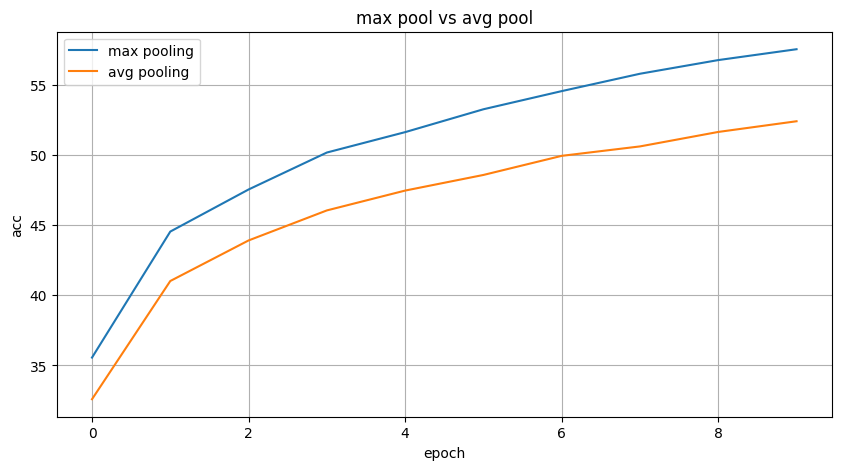

In [52]:
class CNN_avg(nn.Module):
    def __init__(self):
        super(CNN_avg, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(2, 2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(2, 2)
        )
        
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(32 * 8 * 8, 10)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

model_avg = CNN_avg()
optimizer_avg = optim.Adam(model_avg.parameters(), lr=0.0001)
history_avg = train_model(model= model_avg, optimizer=optimizer_avg,epochs=10)

plt.figure(figsize=(10, 5))
plt.plot(acc_tab, label='max pooling') 
plt.plot(history_avg['tr_acc'], label='avg pooling')
plt.title('max pool vs avg pool')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.grid()
plt.show()


tylko tu bedzie tak troche krzywy wykres

In [53]:
summary(CNN_avg().to(device), (1, 3, 32, 32))


Layer (type:depth-idx)                   Output Shape              Param #
CNN_avg                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 16, 32, 32]           448
│    └─ReLU: 2-2                         [1, 16, 32, 32]           --
│    └─AvgPool2d: 2-3                    [1, 16, 16, 16]           --
├─Sequential: 1-2                        [1, 32, 8, 8]             --
│    └─Conv2d: 2-4                       [1, 32, 16, 16]           4,640
│    └─ReLU: 2-5                         [1, 32, 16, 16]           --
│    └─AvgPool2d: 2-6                    [1, 32, 8, 8]             --
├─Flatten: 1-3                           [1, 2048]                 --
├─Linear: 1-4                            [1, 10]                   20,490
Total params: 25,578
Trainable params: 25,578
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.67
Input size (MB): 0.01
Forward/backwar

## 2. eksperyment


In [54]:
class CNN_gap(nn.Module):
    def __init__(self):
        super(CNN_gap, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.gap(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x
    
model_gap = CNN_gap().to(device)
summary(model_gap, (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_gap                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 16, 32, 32]           448
│    └─ReLU: 2-2                         [1, 16, 32, 32]           --
│    └─MaxPool2d: 2-3                    [1, 16, 16, 16]           --
├─Sequential: 1-2                        [1, 32, 8, 8]             --
│    └─Conv2d: 2-4                       [1, 32, 16, 16]           4,640
│    └─ReLU: 2-5                         [1, 32, 16, 16]           --
│    └─MaxPool2d: 2-6                    [1, 32, 8, 8]             --
├─AdaptiveAvgPool2d: 1-3                 [1, 32, 1, 1]             --
├─Flatten: 1-4                           [1, 32]                   --
├─Linear: 1-5                            [1, 10]                   330
Total params: 5,418
Trainable params: 5,418
Non-trainable params: 0
Total mult-a

In [55]:
summary(CNN().to(device), (1, 3, 32, 32))


Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 16, 32, 32]           448
│    └─ReLU: 2-2                         [1, 16, 32, 32]           --
│    └─MaxPool2d: 2-3                    [1, 16, 16, 16]           --
├─Sequential: 1-2                        [1, 32, 8, 8]             --
│    └─Conv2d: 2-4                       [1, 32, 16, 16]           4,640
│    └─ReLU: 2-5                         [1, 32, 16, 16]           --
│    └─MaxPool2d: 2-6                    [1, 32, 8, 8]             --
├─Flatten: 1-3                           [1, 2048]                 --
├─Linear: 1-4                            [1, 10]                   20,490
Total params: 25,578
Trainable params: 25,578
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.67
Input size (MB): 0.01
Forward/backwar

mniejsza liczba parms

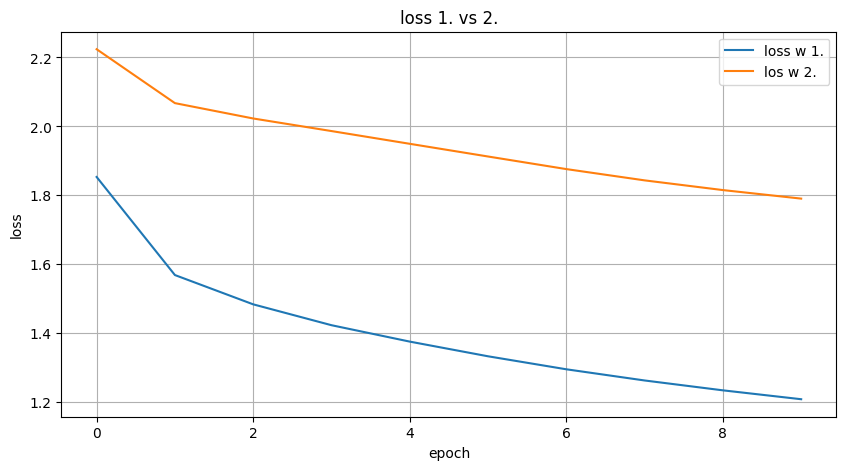

In [56]:
model_2 = CNN_gap().to(device)
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.0001)
history_2 = train_model(model_2, optimizer_2, epochs=10)

plt.figure(figsize=(10, 5))
plt.plot(loss_tab, label='loss w 1.') 
plt.plot(history_2['tr_loss'], label='los w 2.')
plt.title('loss 1. vs 2.')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

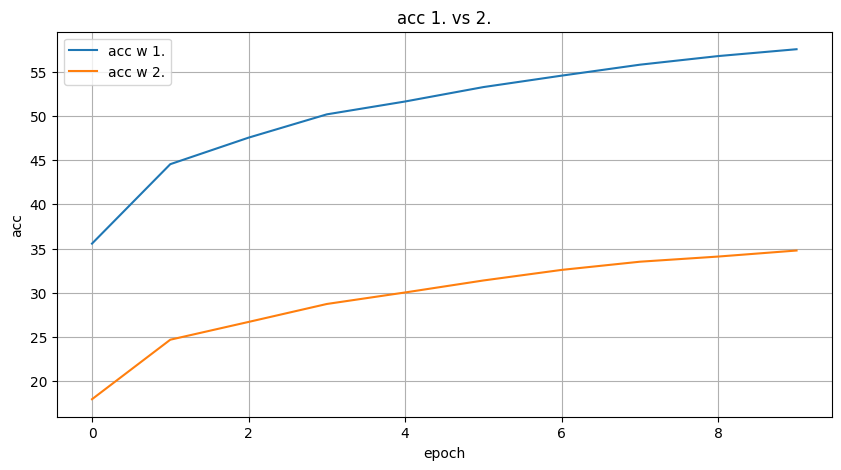

In [57]:
plt.figure(figsize=(10, 5))
plt.plot(acc_tab, label='acc w 1.') 
plt.plot(history_2['tr_acc'], label='acc w 2.')
plt.title('acc 1. vs 2.')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.grid()
plt.show()

## Eksperyment 3


In [58]:
class CNN_dropout(nn.Module):
    def __init__(self):
        super(CNN_dropout, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2)
        )
        
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(32, 10)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

model_3 = CNN_dropout().to(device)
summary(model_3, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_dropout                              [1, 10]                   --
├─Sequential: 1-1                        [1, 32, 8, 8]             --
│    └─Conv2d: 2-1                       [1, 16, 32, 32]           448
│    └─BatchNorm2d: 2-2                  [1, 16, 32, 32]           32
│    └─ReLU: 2-3                         [1, 16, 32, 32]           --
│    └─MaxPool2d: 2-4                    [1, 16, 16, 16]           --
│    └─Dropout2d: 2-5                    [1, 16, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 32, 16, 16]           4,640
│    └─BatchNorm2d: 2-7                  [1, 32, 16, 16]           64
│    └─ReLU: 2-8                         [1, 32, 16, 16]           --
│    └─MaxPool2d: 2-9                    [1, 32, 8, 8]             --
│    └─Dropout2d: 2-10                   [1, 32, 8, 8]             --
├─AdaptiveAvgPool2d: 1-2                 [1, 32, 1, 1]             --
├─Flatten: 

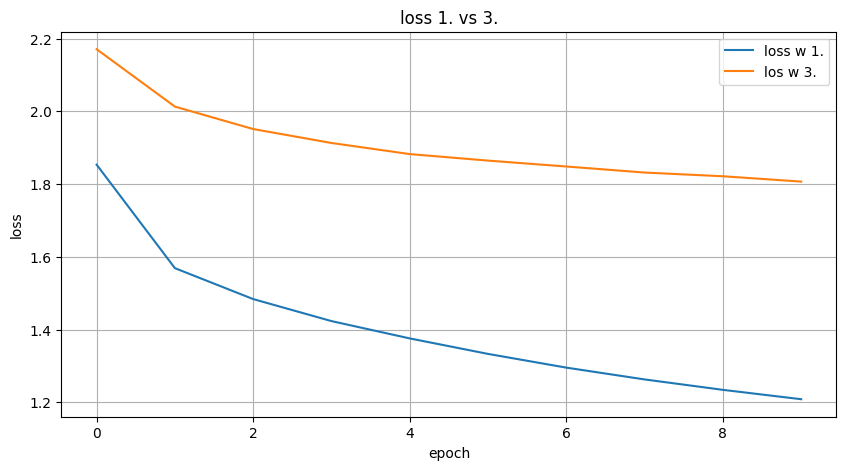

In [59]:
optimizer_3 = optim.Adam(model_3.parameters(), lr=0.0001)
history_3 = train_model(model_3, optimizer_3, epochs=10)

plt.figure(figsize=(10, 5))
plt.plot(loss_tab, label='loss w 1.') 
plt.plot(history_3['tr_loss'], label='los w 3.')
plt.title('loss 1. vs 3.')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

gladszy loss 

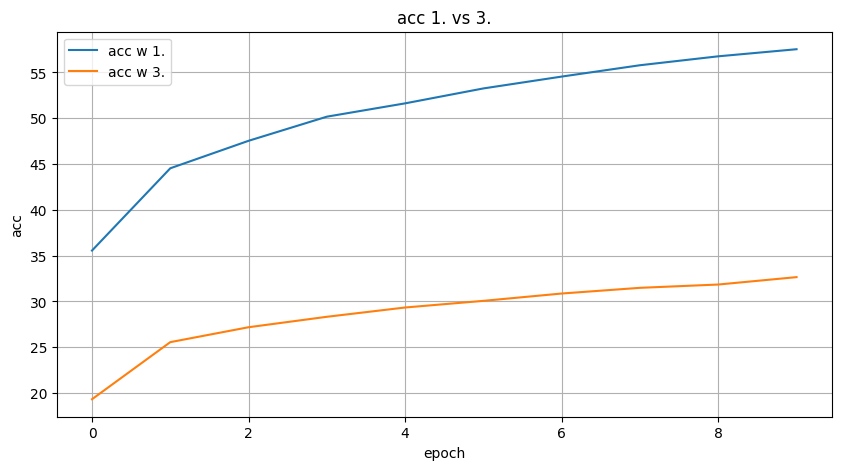

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(acc_tab, label='acc w 1.') 
plt.plot(history_3['tr_acc'], label='acc w 3.')
plt.title('acc 1. vs 3.')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.grid()
plt.show()

slabsze acc

## eksperyment 4


In [61]:
class CNN_deep(nn.Module):
    def __init__(self):
        super(CNN_deep, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2)
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.3)
        )
        
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        
        self.classifier = nn.Linear(128, 10)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.gap(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [62]:
model_4 = CNN_deep().to(device)
summary(model_4, input_size=(1, 3, 32, 32))


Layer (type:depth-idx)                   Output Shape              Param #
CNN_deep                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 32, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           896
│    └─BatchNorm2d: 2-2                  [1, 32, 32, 32]           64
│    └─ReLU: 2-3                         [1, 32, 32, 32]           --
│    └─MaxPool2d: 2-4                    [1, 32, 16, 16]           --
│    └─Dropout2d: 2-5                    [1, 32, 16, 16]           --
├─Sequential: 1-2                        [1, 64, 8, 8]             --
│    └─Conv2d: 2-6                       [1, 64, 16, 16]           18,496
│    └─BatchNorm2d: 2-7                  [1, 64, 16, 16]           128
│    └─ReLU: 2-8                         [1, 64, 16, 16]           --
│    └─MaxPool2d: 2-9                    [1, 64, 8, 8]             --
│    └─Dropout2d: 2-10                   [1, 64, 8, 8]             --
├─Sequent

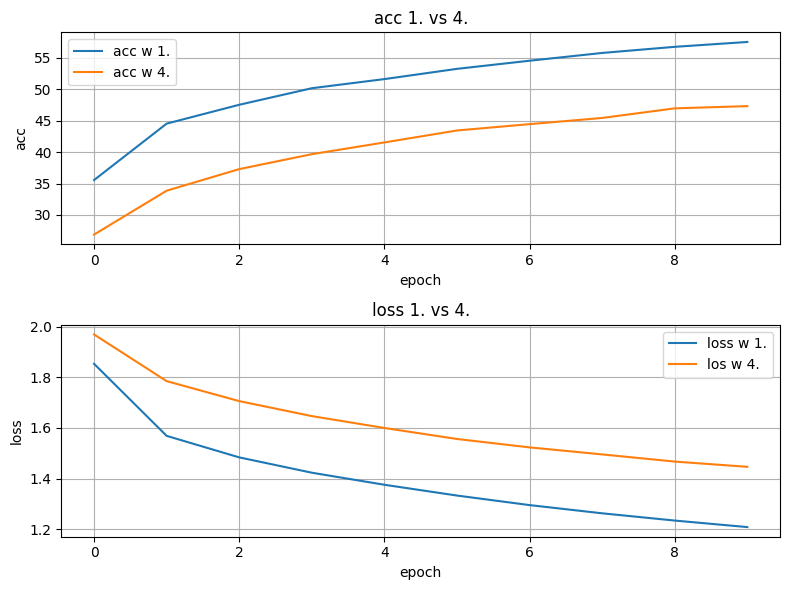

In [63]:
optimizer_4 = optim.Adam(model_4.parameters(), lr=0.0001)
history_4 = train_model(model_4, optimizer_4, epochs=10)

plt.figure(figsize=(8, 6))
plt.subplot(2,1,1)
plt.plot(acc_tab, label='acc w 1.') 
plt.plot(history_4['tr_acc'], label='acc w 4.')
plt.title('acc 1. vs 4.')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(loss_tab, label='loss w 1.') 
plt.plot(history_4['tr_loss'], label='los w 4.')
plt.title('loss 1. vs 4.')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## eksperymten 5 


In [64]:
class CNN_par(nn.Module):
    def __init__(self):
        super(CNN_par, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=2, dilation=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.relu = nn.ReLU()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(64, 10)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.gap(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

model_5 = CNN_par().to(device)
summary(model_5, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_par                                  [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 16, 16]           896
├─BatchNorm2d: 1-2                       [1, 32, 16, 16]           64
├─ReLU: 1-3                              [1, 32, 16, 16]           --
├─Conv2d: 1-4                            [1, 64, 8, 8]             18,496
├─BatchNorm2d: 1-5                       [1, 64, 8, 8]             128
├─ReLU: 1-6                              [1, 64, 8, 8]             --
├─AdaptiveAvgPool2d: 1-7                 [1, 64, 1, 1]             --
├─Flatten: 1-8                           [1, 64]                   --
├─Linear: 1-9                            [1, 10]                   650
Total params: 20,234
Trainable params: 20,234
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.41
Input size (MB): 0.01
Forward/backward pass size (MB): 0.20
Params size (MB): 0.08
Estimated Total Size (MB)

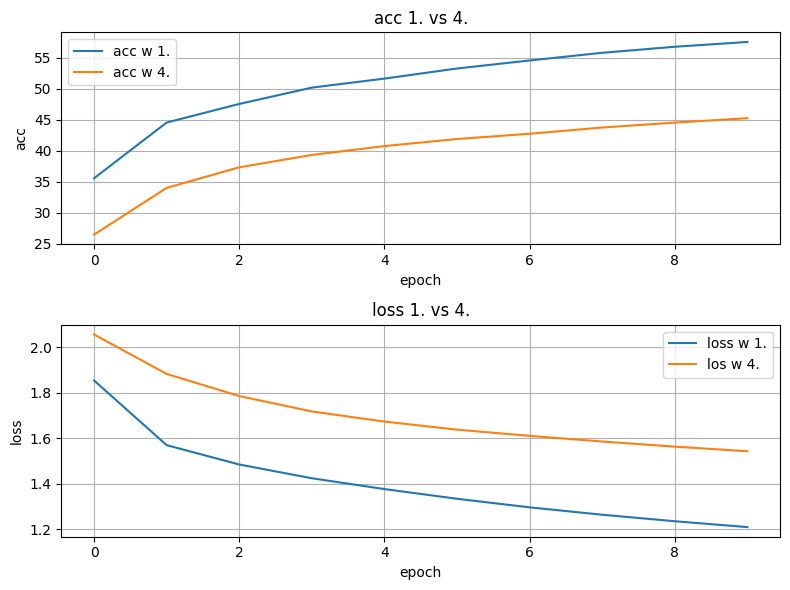

In [65]:
optimizer_5 = optim.Adam(model_5.parameters(), lr=0.0001)
history_5 = train_model(model_5, optimizer_5, epochs=10)

plt.figure(figsize=(8, 6))
plt.subplot(2,1,1)
plt.plot(acc_tab, label='acc w 1.') 
plt.plot(history_5['tr_acc'], label='acc w 4.')
plt.title('acc 1. vs 4.')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(loss_tab, label='loss w 1.') 
plt.plot(history_5['tr_loss'], label='los w 4.')
plt.title('loss 1. vs 4.')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# podsumowanie

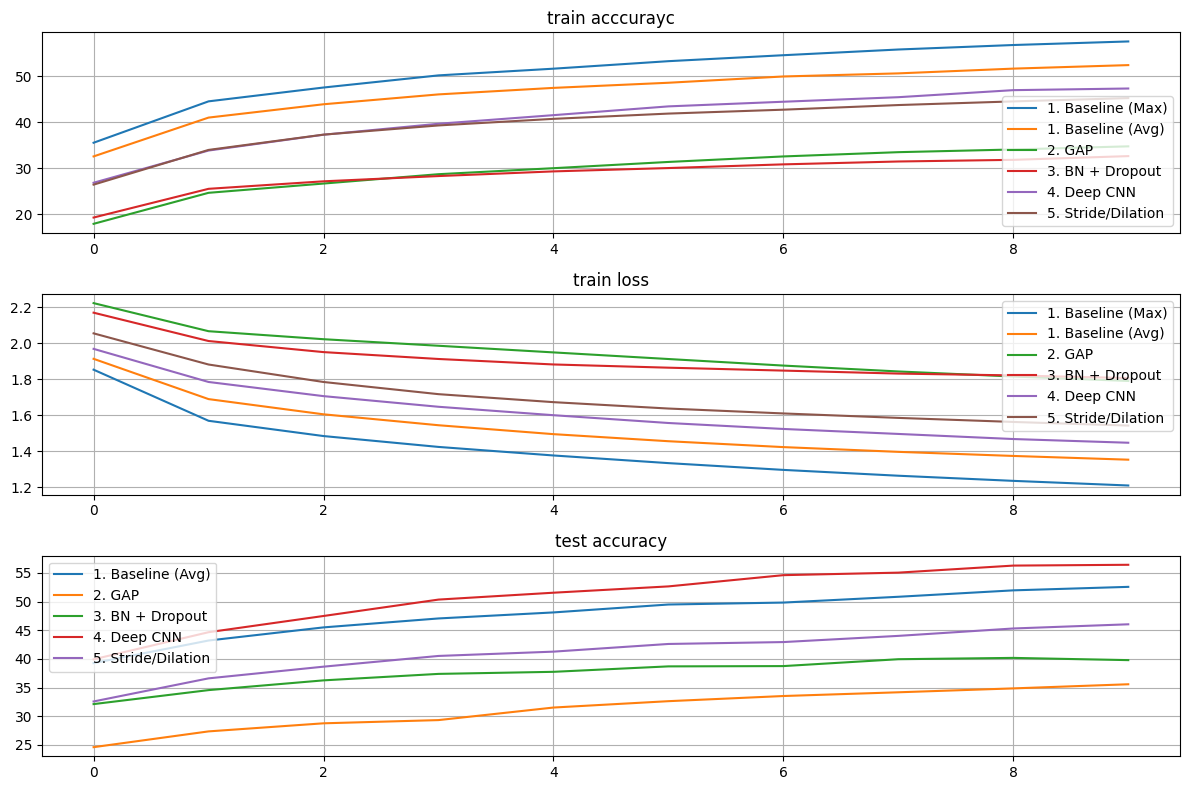

In [67]:
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
plt.title('train acccurayc')
plt.plot(acc_tab, label='1. Baseline (Max)')
plt.plot(history_avg['tr_acc'], label='1. Baseline (Avg)')
plt.plot(history_2['tr_acc'], label='2. GAP')
plt.plot(history_3['tr_acc'], label='3. BN + Dropout')
plt.plot(history_4['tr_acc'], label='4. Deep CNN')
plt.plot(history_5['tr_acc'], label='5. Stride/Dilation')
plt.grid()
plt.legend()

plt.subplot(3,1,2)
plt.title('train loss')
plt.plot(loss_tab, label='1. Baseline (Max)')
plt.plot(history_avg['tr_loss'], label='1. Baseline (Avg)')
plt.plot(history_2['tr_loss'], label='2. GAP')
plt.plot(history_3['tr_loss'], label='3. BN + Dropout')
plt.plot(history_4['tr_loss'], label='4. Deep CNN')
plt.plot(history_5['tr_loss'], label='5. Stride/Dilation')
plt.grid()
plt.legend()

plt.subplot(3,1,3)
plt.title('test accuracy')
plt.plot(history_avg['test_acc'], label='1. Baseline (Avg)')
plt.plot(history_2['test_acc'], label='2. GAP')
plt.plot(history_3['test_acc'], label='3. BN + Dropout')
plt.plot(history_4['test_acc'], label='4. Deep CNN')
plt.plot(history_5['test_acc'], label='5. Stride/Dilation')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## wnioski

Najlepszym modelem okazał się ten z eksperymentu 4, ponieważ łączy w sobie nowoczesne techniki regularyzacji (GAP, BN, Dropout) z odpowiednią głębokością architektury. jego czas trenowania również zajął najdłużej. Troche przesadziłem robiąc base line powinienm zrobic prostrzy model aby było widać lepiej wyniki. nasz model 4 ma nawieksza ilosc parametrow 95 k, 
<br>
natomias najmniejsza ma model 2 5k, metoda redukcji wymiarowości może gubić zbyt wiele istotnych informacji dlatego ma tak salbe acc
<br>
modele byly uczone an 10 epokach bo nie chcialo mi sie dluzej czeka, przy zwiekszeniu ilosci epok modele prawodopodobnie dawalby lepssze wyniki  

### *Zadanie 5 (dla chętnych)

Wykorzystaj [CAM](https://zilliz.com/learn/class-activation-mapping-CAM) do wizualizacji aktywacji konwolucji dla kilku przykładów ze zbioru testowego. Do tego celu twoja sieć musi koniecznie mieć warstwę Global Avg Pooling, a końcowy moduł FNN być jednowarstwowy.